In [16]:
import pandas as pd
from pathlib import Path
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest, chi2, SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from skfeature.function.similarity_based import fisher_score


In [17]:
starter_df = pd.read_csv(Path("c://users/ajcth/documents/github/bank_churn_model/Resources/BankChurnersPrimary.csv"))
starter_df.sample(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
5312,715954158,Attrited Customer,48,M,3,Post-Graduate,Married,$40K - $60K,Blue,36,...,2954.0,931,2023.0,0.575,2433,29,0.381,0.315,0.997500,0.002501
6024,712574583,Existing Customer,34,F,1,Graduate,Single,Unknown,Blue,21,...,6376.0,1322,5054.0,0.709,5192,70,0.628,0.207,0.000087,0.999910
7202,815515158,Existing Customer,49,F,2,Unknown,Single,$40K - $60K,Blue,44,...,2147.0,1402,745.0,0.612,4240,69,0.683,0.653,0.000102,0.999900
9276,718102758,Existing Customer,61,F,0,High School,Married,Less than $40K,Blue,36,...,3175.0,1116,2059.0,0.978,14071,101,0.683,0.351,0.000077,0.999920
5637,780584658,Attrited Customer,33,F,2,Uneducated,Unknown,$40K - $60K,Blue,22,...,1843.0,1293,550.0,0.349,2077,61,0.694,0.702,0.991530,0.008470


In [18]:
starter_df.drop(columns=[
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'CLIENTNUM',
'Education_Level', 
'Marital_Status', 
'Income_Category'
], 
inplace= True)

In [19]:

enc = OneHotEncoder(sparse=False)
categorical_variables = ['Card_Category']
encoded_data = enc.fit_transform(starter_df[categorical_variables])
encoded_dataframe = pd.DataFrame(encoded_data, columns = enc.get_feature_names(categorical_variables))
starter_df.drop(columns=['Card_Category'], inplace=True)
starter_df = pd.concat([starter_df, encoded_dataframe.set_axis(starter_df.index)], axis=1)
starter_df.sample(10)

c:\python_files\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
3071,Existing Customer,46,M,2,41,3,3,2,10077.0,0,10077.0,0.639,2118,52,0.576,0.000,1.0,0.0,0.0,0.0
5527,Attrited Customer,48,F,4,36,5,2,2,2700.0,2480,220.0,0.686,2396,49,0.531,0.919,1.0,0.0,0.0,0.0
8973,Existing Customer,38,M,3,36,2,2,3,34516.0,2008,32508.0,0.858,8872,86,0.593,0.058,0.0,0.0,0.0,1.0
1766,Existing Customer,56,M,2,49,4,1,4,8902.0,1932,6970.0,0.781,969,29,1.071,0.217,1.0,0.0,0.0,0.0
6969,Existing Customer,52,F,0,34,4,4,3,2001.0,960,1041.0,0.678,4026,86,0.830,0.480,1.0,0.0,0.0,0.0
3391,Existing Customer,45,F,2,36,4,2,4,7738.0,947,6791.0,0.845,4255,61,0.694,0.122,1.0,0.0,0.0,0.0
8261,Existing Customer,56,F,1,50,2,3,3,5338.0,0,5338.0,0.919,4139,69,0.865,0.000,1.0,0.0,0.0,0.0
107,Existing Customer,44,M,1,36,5,2,3,14450.0,2440,12010.0,1.283,1235,30,0.667,0.169,1.0,0.0,0.0,0.0
2256,Existing Customer,34,F,1,25,4,3,3,2318.0,2069,249.0,1.399,2689,57,0.781,0.893,1.0,0.0,0.0,0.0
7277,Attrited Customer,37,F,3,29,3,3,3,1653.0,0,1653.0,0.517,2284,35,0.296,0.000,1.0,0.0,0.0,0.0


In [20]:
starter_df = starter_df.replace({'Gender' : {
'M': 0, 
'F': 1
}})
starter_df.Gender = starter_df.Gender.astype(int)

In [21]:
starter_df = starter_df.replace({'Attrition_Flag' : {
'Attrited Customer': 0, 
'Existing Customer': 1
}})
starter_df.Attrition_Flag = starter_df.Attrition_Flag.astype(int)

In [22]:
y = starter_df['Attrition_Flag']
X = starter_df.drop(columns=['Attrition_Flag'])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.987


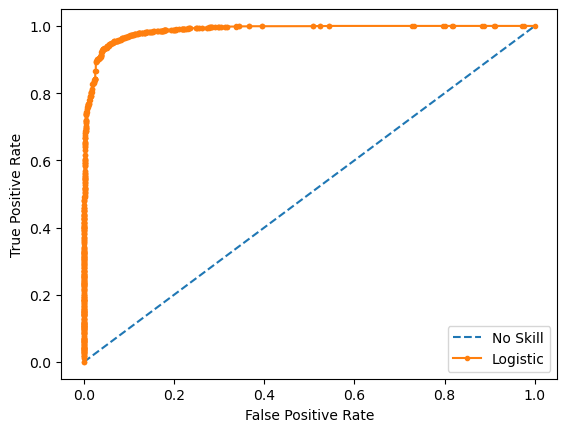

In [23]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = GradientBoostingClassifier()
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()